### Reference

see [Unsupervised outlier detection in multidimensional data](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00469-z)

In [1]:
import logging
import threading
import itertools
import json

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np  
import scipy as sp
import ruptures as rpt

from sklearn import cluster, datasets, mixture
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import covariance
from sklearn.neighbors import (KernelDensity, NearestNeighbors, kneighbors_graph)
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn.utils import check_array

import skimage as ski
from skimage import util as skiutil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
register_matplotlib_converters()

### Slide 8: Anomalies in time series data

In [2]:
Temperature = 'temperature'

# Get stuff in
df_i = pd.read_csv('./data/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i[Temperature]=df_i['value']
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

<AxesSubplot:xlabel='timestamp'>

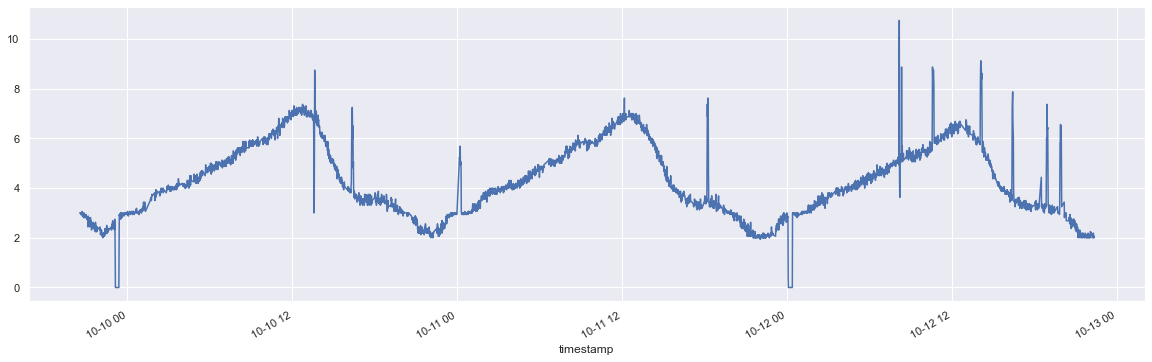

In [3]:
df_i.loc['MyRoom'][Temperature].plot(figsize=(20,6))

#### Time series motifs

Text(0.5, 1.0, '"Normal"')

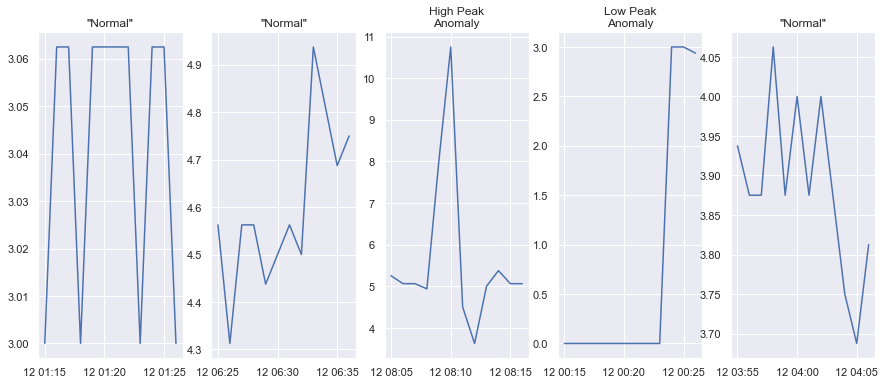

In [4]:
rg1=slice(2853,2865)
rg2=slice(3153,3165)
rg3=slice(3253,3265)
rg4=slice(2803,2815)
rg5=slice(3003,3015)
fig,ax = plt.subplots(1,5, figsize=(15, 6))
temperature = df_i['value'].values
ax[0].plot(df_i.loc['MyRoom'][rg1][Temperature])
ax[0].set_title('\"Normal\"')
ax[1].plot(df_i.loc['MyRoom'][rg2][Temperature])
ax[1].set_title('\"Normal\"')
ax[2].plot(df_i.loc['MyRoom'][rg3][Temperature])
ax[2].set_title('High Peak\nAnomaly')
ax[3].plot(df_i.loc['MyRoom'][rg4][Temperature])
ax[3].set_title('Low Peak\nAnomaly')
ax[4].plot(df_i.loc['MyRoom'][rg5][Temperature])
ax[4].set_title('\"Normal\"')

### Slide 9: Decomposing time series data

[None]

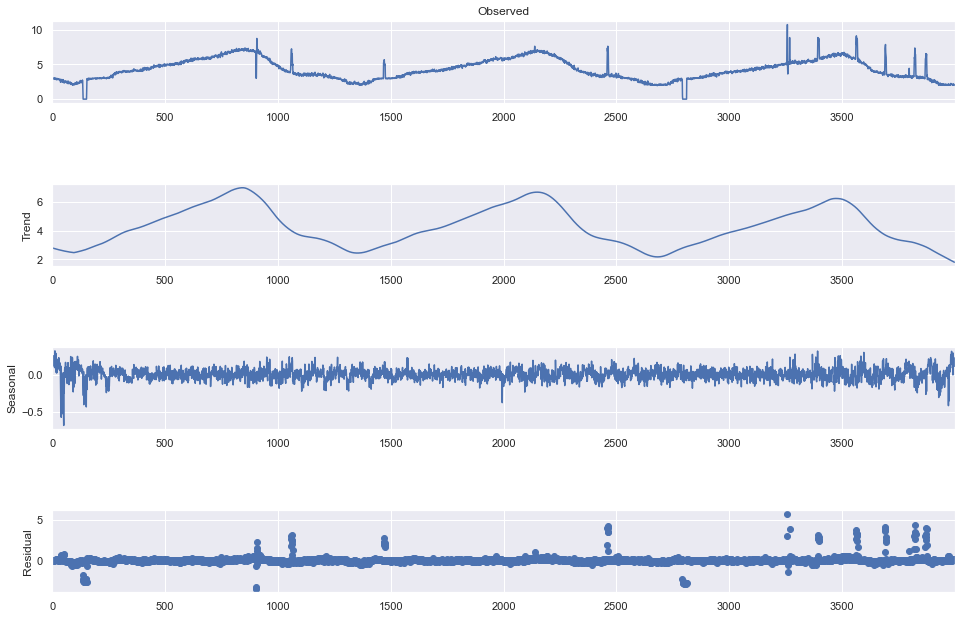

In [5]:
from statsmodels.tsa.seasonal import STL

stl=STL(df_i['value'].values, period=100, robust=True)
result = stl.fit()

fig = result.plot()
fig.set(size_inches=(15,10))
#fig.set_size(15,10)

### Slide 9: Feature extraction - finding strange motifs in the frequency space

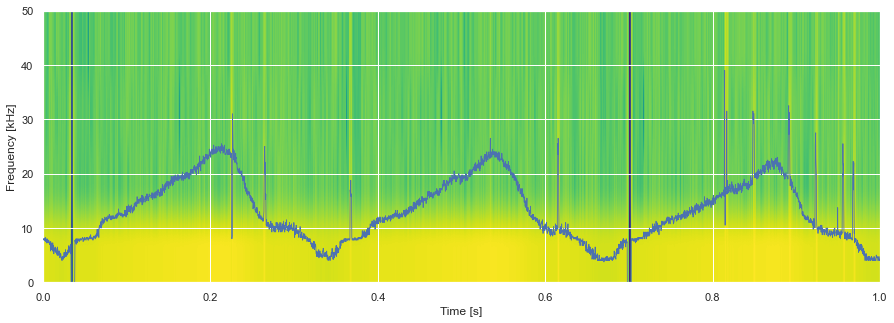

In [6]:
temperature = df_i['value'].values


M=12
slices = skiutil.view_as_windows(temperature, window_shape=(M,))
small = 10**(-8)

hann = np.hanning(M + 1)[:-1]
slices = slices * hann
slices = slices.T

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)
spectrum[spectrum < small] = small
max_spec = np.max(spectrum)

fig, ax = plt.subplots(1, 1, figsize=(15,5), squeeze=False)
S = 20 * np.log10(spectrum / max_spec)
ax[0,0].imshow(S, origin='lower', cmap='viridis', extent=(0, 1, 0, 100 / 2))
ax[0,0].axis('tight')
ax[0,0].set_ylabel('Frequency [kHz]')
ax[0,0].set_xlabel('Time [s]')

ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/4000, temperature*4-4, lw=0.8, zorder=10)

#### Time series motifs in frequency domain

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, '"Bottom up"\nAnomaly\nFrequency domain')

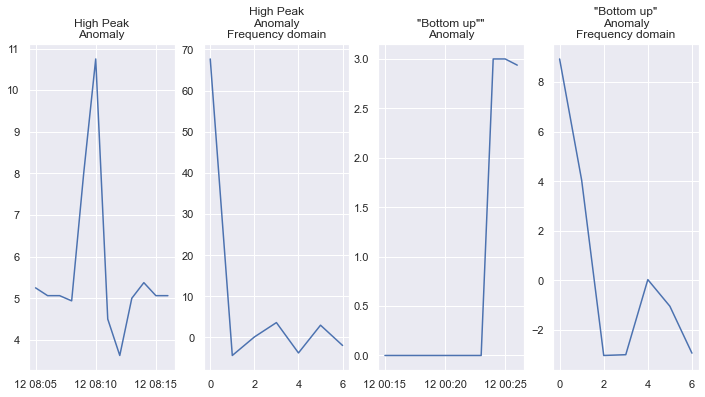

In [7]:
temp_fft1 = sp.fft.rfft(temperature[rg3])
temp_fft2 = sp.fft.rfft(temperature[rg4])

#xf = sp.fft.fftfreq(12,1/12)[0:6]

fig,ax = plt.subplots(1,4, figsize=(12, 6))
temperature = df_i['value'].values
ax[0].plot(df_i.loc['MyRoom'][rg3][Temperature])
ax[0].set_title('High Peak\nAnomaly')
ax[1].plot(temp_fft1)
ax[1].set_title('High Peak\nAnomaly\nFrequency domain')
ax[2].plot(df_i.loc['MyRoom'][rg4][Temperature])
ax[2].set_title('\"Bottom up\""\nAnomaly')
ax[3].plot(temp_fft2)
ax[3].set_title('\"Bottom up\"\nAnomaly\nFrequency domain')

### Slide 10: Anomalies – motifs projected to 2 dimensions

In [8]:
import umap
import umap.plot

X = skiutil.view_as_windows(temperature, window_shape=(12,), step=1)
mapper = umap.UMAP(densmap=True, n_neighbors=30).fit(X)

2022-07-25 18:06:18.960109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 18:06:18.960126: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


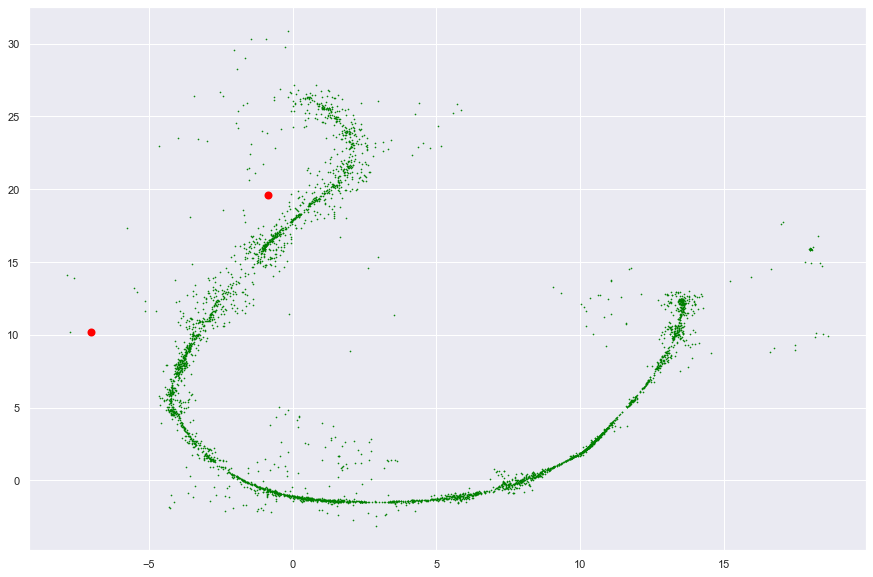

In [9]:
XX = mapper.transform(X)

#umap.plot.points(mapper)
fig, ax = plt.subplots(1,1, figsize=(15,10))
#ax.set_xlim()
#ax.scatter(XX[:, 0], XX[:, 1],
#            c=kmeans.predict(XX), s=0.4, lw=1, cmap='Spectral')
ax.scatter(XX[:, 0], XX[:, 1],
            c='green', s=0.4, lw=1, cmap='Spectral')
ax.scatter(mapper.transform(X)[3253:3255, 0], mapper.transform(X)[3253:3255, 1],
            c='red', lw=2, zorder=1)


In [10]:
### Slide 11: 

### KMeans: Expectation Maximization like iterations

In [22]:
K=40
# select 4 centers 
rng = np.random.default_rng()
center_index = rng.choice(X.shape[0], size=K, replace=False)

Labels = np.zeros((X.shape[0], K))


#fig,ax = plt.subplots(4,1,figsize=(10, 20))

for cnt in range(20):
    # assign elements to clusters
    labels = np.zeros_like(X[:, 0]).astype(int)
    dists = np.zeros_like(X[:, 0])

    centers_ = []

    for j in range(K):
        centers_.append(X[center_index[j]])
    centers = np.array(centers_)


    for i in range(X.shape[0]):
        dist_to_center = np.linalg.norm(centers - X[i], axis=1)
        labels[i] = np.argmin(dist_to_center)
        
    #if cnt % 4 == 0:    
    #   Labels[:,cnt%4] = labels.copy()
        
    #ax[cnt].scatter(X[:, 0], X[:, 1], c=Labels[:,cnt%4], cmap='viridis');
    
    #input("Press Enter to continue...")
    
    # select new centroids - M step

    
    center_index_ = []
    # cluster by cluster
    for i in range(K):
        
        elements_ = []
        index_ = []
        for j in range(X.shape[0]):
            if labels[j] == i: 
                elements_.append(X[j])
                index_.append(j)
        elements = np.array(elements_)
        index = np.array(index_)
        
        dist_to_center_ = []
        for j in range(elements.shape[0]):
            dist_to_center_.append(np.linalg.norm(elements - elements[j]))
        dist_to_center = np.array(dist_to_center_)
        center_index_.append(index[np.argmin(dist_to_center)])
    
    center_index = np.array(center_index_)
        
        

#### sorted motifs in large and small clusters

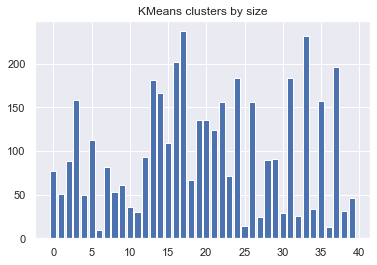

In [26]:
# find large and small clusters
n_ = []
for j in range(40):
    n_.append(labels.shape[0] - np.count_nonzero(labels - j))
n = np.array(n_)
plt.bar(range(n.size),n)
plt.title('KMeans clusters by size')

small = []
for j in range(40):
    if n[j] < 30: small.append(j)

In [27]:
small

[6, 25, 27, 30, 32, 36]

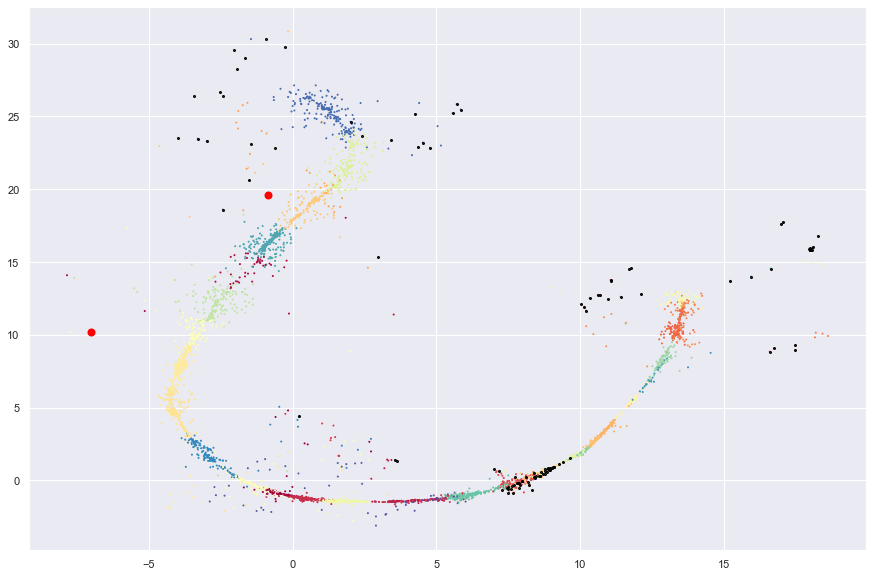

In [28]:
#umap.plot.points(mapper)
fig, ax = plt.subplots(1,1, figsize=(15,10))
#ax.set_xlim()
ax.scatter(XX[:, 0], XX[:, 1],
            c=labels, s=1, lw=1, cmap='Spectral')
for i in range(XX.shape[0]):
    if labels[i] in small:
        ax.scatter(XX[i,0], XX[i,1], s=1, lw=2, c='black')
ax.scatter(XX[3253:3255, 0], XX[3253:3255, 1],
            c='red', lw=2, zorder=1)

### Slide 12: Anomalies – another approach: covariance

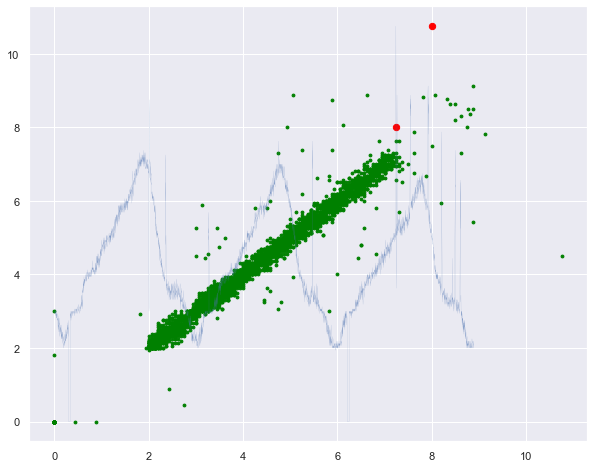

In [29]:
temp_win = skiutil.view_as_windows(temperature, window_shape=(2,), step=1)

fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=8, c='green', cmap='viridis')
#ax[0,0].axis('tight')
#ax[0,0].set_ylabel('Frequency [kHz]')
#ax[0,0].set_xlabel('Time [s]')

ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)
ax[0,0].scatter(temp_win[3257, 0], temp_win[3257, 1], s=40, c='red')
ax[0,0].scatter(3257/450, temperature[3257], s=40, c='red')

### Slide 13: Anomalies – another approach: covariance II


In [30]:
#cov_e = covariance.EllipticEnvelope(support_fraction=1.0, random_state=42).fit(temp_win)
cov_m = covariance.EllipticEnvelope(random_state=42).fit(temp_win)
n = cov_m.score_samples(temp_win)
n2 = np.log(-n*4)
max(n2)

9.070460589119945

/tmp/ipykernel_2690120/2137024652.py:17: UserWarning: The following kwargs were not used by contour: 's', 'c'
  ax[0,0].contour(xx1, yy1, -Zm, s=2, levels=[14.0], c='red')


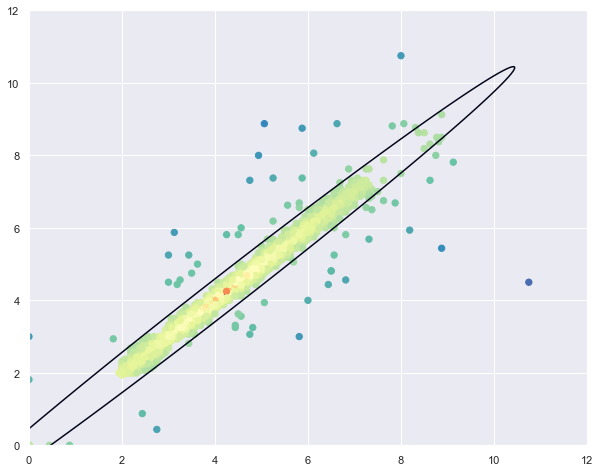

In [31]:
xx1, yy1 = np.meshgrid(np.linspace(0, 12, 500), np.linspace(0, 12, 500))
#Ze = cov_e.decision_function(np.c_[xx1.ravel(), yy1.ravel()]).reshape(xx1.shape)
Zm = cov_m.decision_function(np.c_[xx1.ravel(), yy1.ravel()]).reshape(xx1.shape)


fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=40, c=n2, cmap='Spectral', vmin=min(n2), vmax=max(n2)+1)
#ax[0,0].axis('tight')
#ax[0,0].set_ylabel('Frequency [kHz]')
#ax[0,0].set_xlabel('Time [s]')

#ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)
#ax[0,0].scatter(temp_win[3257, 0], temp_win[3257, 1], s=80, c='green')
#ax[0,0].contour(xx1, yy1, -Ze, s=2, levels=[14.0], c='red')

ax[0,0].contour(xx1, yy1, -Zm, s=2, levels=[14.0], c='red')

#ax[0,0].scatter(3257/450, temperature[3257], s=80, c='lightgreen')

### Slide 14: Matrix profile: comparing motifs with its neighbors

In [32]:
#### Matrix profile: brute force
distance_ = []
profile_ = []
excl = 4
for i in range(temp_win.shape[0]):
    # cross correlation is equivalent by taking the dot product of fourier transform and fourier transform's
    # conjugate IFFT{  FFT(temp_win) DOT np.conjugate(FFT(temp_win[i])) }
    # we won't do that here
    d = np.linalg.norm(temp_win - temp_win[i], axis=1)
    d[max(i-excl,0):min(i+excl,temp_win.shape[0])] = 10**6
    distance_.append(np.min(d))
    profile_.append(abs(np.argmin(d)-i))

matrix_distance = np.array(distance_)
matrix_profile = np.array(profile_)

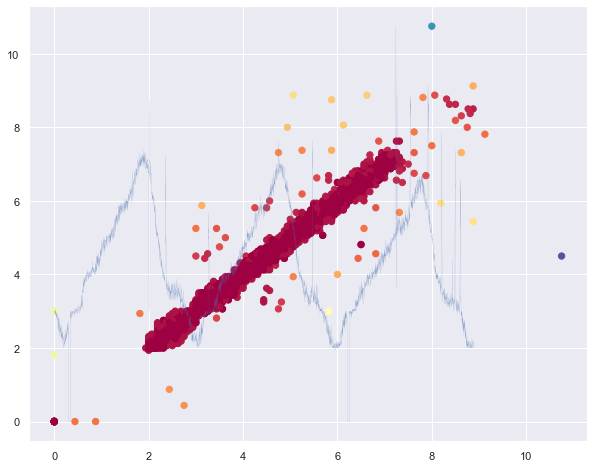

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=40, c=matrix_distance, cmap='Spectral') #, vmin=min(n2), vmax=max(n2)+1)
#ax[0,0].contour(xx1, yy1, -Zm, s=2, levels=[14.0], c='red')
#ax[1,0].plot(range(temp_win.shape[0]), matrix_profile)
ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)

### Slide 15: Isolation forest

In [34]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(random_state=42, contamination=0.1).fit(temp_win)


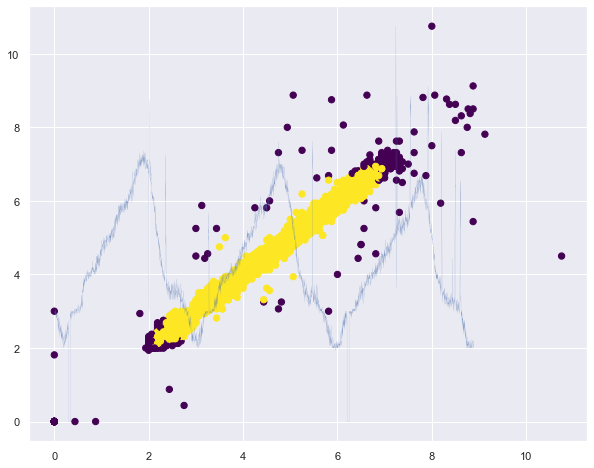

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=40, c=iso.predict(temp_win), cmap='viridis')
ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)

In [36]:
from srom.anomaly_detection.algorithms.deep_isolation_forest import DeepIsolationForest

dif = DeepIsolationForest()
print('Shape of the input data', temp_win.shape)

dif2 = dif.fit(temp_win)

print(len(dif2.net_lst_), ' random one-layer networks ')

print(dif2.net_lst_[0].summary())

Shape of the input data (3999, 2)


2022-07-25 18:18:33.831549: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-25 18:18:33.831614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: markus-ThinkPad-P53
2022-07-25 18:18:33.831619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: markus-ThinkPad-P53
2022-07-25 18:18:33.831777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-07-25 18:18:33.831807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-07-25 18:18:33.832306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other ope

50  random one-layer networks 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (3999, 20)                40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
None


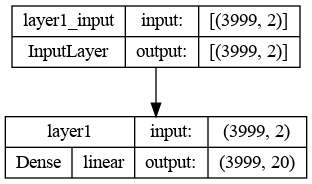

In [41]:
import tensorflow as tf
tf.keras.utils.plot_model(dif2.net_lst_[0], to_file='my_model.png', show_shapes=True, show_layer_activations=True)
#pydot('my_model.png')

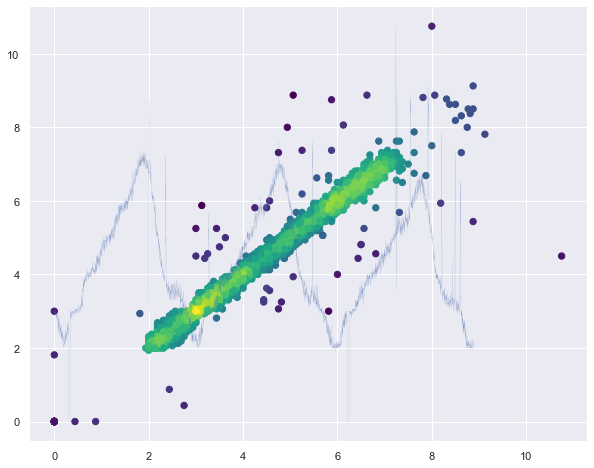

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), squeeze=False)

ax[0,0].scatter(temp_win[:, 0], temp_win[:, 1], s=40, c=dif2.decision_function(temp_win), cmap='viridis')
ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/450, temperature, lw=0.08, zorder=10)

### Slide 28: On pipeline scheduling, event rates and anomaly scoring

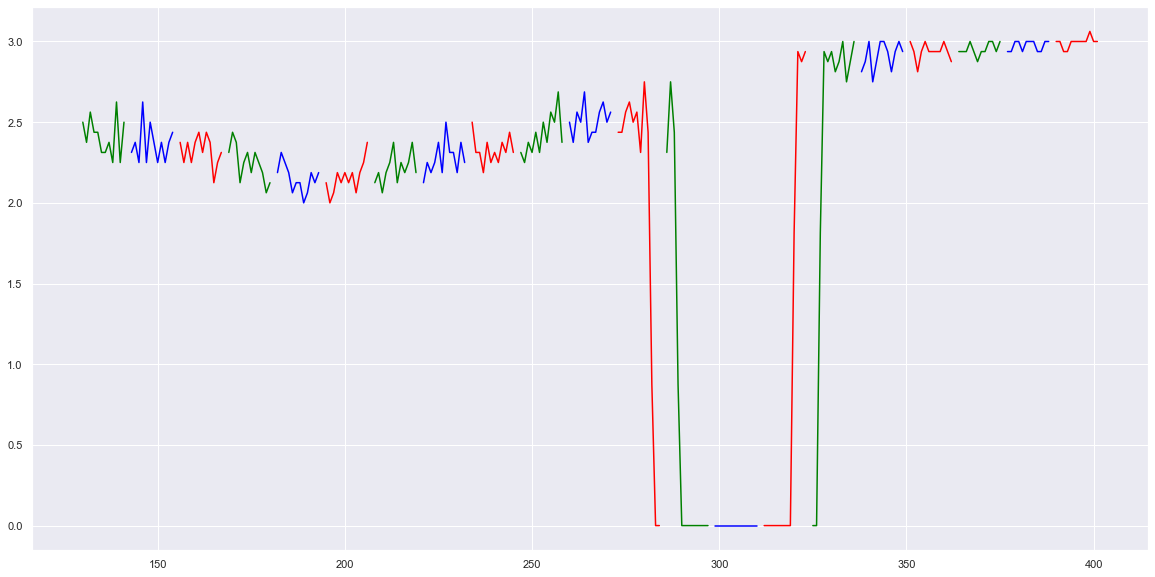

In [64]:
temp_win12 = skiutil.view_as_windows(temperature, window_shape=(12,), step=6)
colors = ['red','green','blue']

fig, ax = plt.subplots(1,1,figsize=(20,10))

for i in range(10, temp_win12.shape[0]):
    #color = plt.cm.hsv(i/temp_win12.shape[0])
    color = plt.cm.hsv(i)
    ax.plot(range(i*13,i*13+12), temp_win12[i,:], c=colors[i%3])
    if i>29:    break

### End

### Project to 1-dim

Actually this is very close to KNN density estimation with

$$
    localDensity = \frac{k}{N} \frac{1}{Volume \ of d_{k} Sphere}
$$

### Apply a convolution like scheme

#### Schema 2

Use a Gaussian like kernel (N = dimension)

$$
    f_i(x) = \frac{\zeta_i^N}{\pi} \exp^{- \frac{(x-x_i)^2}{\zeta^N}}
$$
    
    and sort of a variable bandwidth estimator
    using the KNN results as local density approximation
    
$$       
    \zeta_i = \frac{\gamma}{(1 + d_i)^N}
$$
    Then define
$$
    Z(x) = \sum_i f_i(x)  \approx \int_{I} f_i(x) dI
$$
    and use a normalizer
$$
    T = \alpha \max_{i}(Z(x_i))
$$

For a reference the following wikipedia article about [Variable KDE](https://en.wikipedia.org/wiki/Variable_kernel_density_estimation) is a good starting point, but it doesn't cover the usage of KNN approximation to the local density as input for ballooning.

In [80]:
# Hyperparms
gamma = 1.1
alpha = 0.1
N = 2  # dimension

zeta_ = []
zett = np.zeros_like(k_distances)
for idx, d_k in np.ndenumerate(k_distances):
    zeta_i = gamma/(1 + d_k)**N
    zeta_.append(zeta_i)
    # offset variance 
    #zett += zeta_i**4 * sp.stats.multivariate_normal.pdf(X, mean=X[idx,:].reshape(-1,), cov=zeta_i)
    # much cheaper
    zett += zeta_i**4 * sp.stats.norm.pdf(np.linalg.norm(X - X[idx,:], 2, axis=1), loc=0.0, scale=zeta_i)
zeta = np.array(zeta_)

T = alpha * max(zett)

In [81]:
T

5.9509281202446935

In [74]:
#X[idx,:].reshape(2,-1).shape, X.reshape(2,-1).shape
np.linalg.norm(X - X[idx,:], 2, axis=1)

array([ 0.        , 10.00056739,  8.95007105, ...,  7.7063761 ,
        6.03216725, 17.93495886])

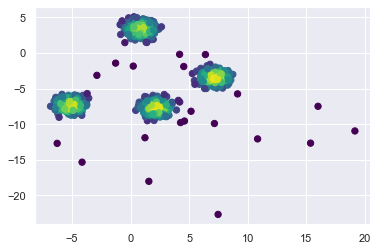

In [82]:
plt.scatter(X[:, 0], X[:, 1], c=zett, s=40, cmap='viridis')

Text(0.5, 1.0, 'Show the outliers')

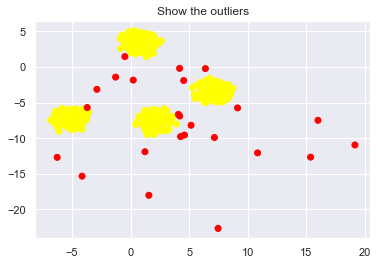

In [83]:
plt.scatter(X[:, 0], X[:, 1], c=(zett > T), cmap='autumn')
plt.title('Show the outliers')

In [94]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(temp_win)
k = 7
dist, indices = nbrs.kneighbors(temp_win)
# find distance to k-th nearest neighbor
k_distances = np.array([dist[i][k - 1] for i in range(len(dist))])

In [95]:
# Hyperparms
gamma = 1.1
alpha = 0.1
N = 2  # dimension

zeta_ = []
zett = np.zeros_like(k_distances)
for idx, d_k in np.ndenumerate(k_distances):
    zeta_i = gamma/(1 + d_k)**N
    zeta_.append(zeta_i)
    # offset variance 
    zett += zeta_i**4 * sp.stats.multivariate_normal.pdf(temp_win, mean=temp_win[idx,:].reshape(-1,), cov=zeta_i)
zeta = np.array(zeta_)

T = alpha * max(zett)

Text(0.5, 1.0, 'Show the outliers (in red)')

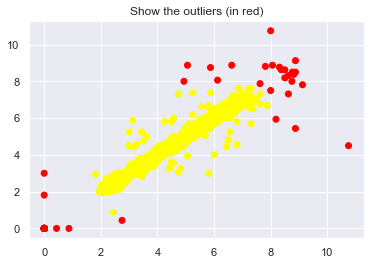

In [97]:
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=(zett > T), cmap='autumn')
plt.title('Show the outliers (in red)')